# Import Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import psutil
import time

# Use TensorFlow's Keras, not standalone Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

import warnings
warnings.filterwarnings("ignore")


# measure_usage 

In [4]:
def measure_usage(func):
    def wrapper(*args, **kwargs):
        process = psutil.Process()
        cpu_times_pre = process.cpu_times()
        memory_use_pre = process.memory_info().rss  # rss = Resident Set Size

        start_time = time.time()
        result = func(*args, **kwargs)
        end_time = time.time()

        cpu_times_post = process.cpu_times()
        memory_use_post = process.memory_info().rss

        cpu_time_used = (cpu_times_post.user - cpu_times_pre.user) + (cpu_times_post.system - cpu_times_pre.system)
        memory_used = memory_use_post - memory_use_pre
        execution_time = end_time - start_time

        print(f"Function: {func.__name__}")
        print(f"CPU time used: {cpu_time_used:.2f} sec")
        print(f"Memory used: {memory_used / (1024**2):.2f} MB")  # Convert bytes to MB
        print(f"Execution time: {execution_time:.2f} sec")
        return result
    return wrapper

# Class module

In [5]:
class LSTM_predictions():
    def __init__(self,df,pred_column,date_col = "timestamp",epoch=10):
        self.df = df
        self.df.dropna(inplace=True)
        self.epoch = epoch
        print("Columns: ",self.df.columns)
        print("Data shape: ",self.df.shape)
        self.df[date_col] = pd.to_datetime(self.df[date_col], errors='coerce')
        self.df = self.df[[date_col,pred_column]]
        print("*"*60)

        data = df.filter([pred_column])
        dataset = data.values

        # Get the number of rows to train the model on
        training_data_len = int(np.ceil( len(dataset) * .80 ))
        train_data = df.iloc[0:int(training_data_len), :]
        test_data = df.iloc[training_data_len - 60: , :]   

        print("Train size :",train_data.shape)
        print("Test size :",test_data.shape)

        self.train_data = train_data[[pred_column, date_col]].to_numpy()
        self.test_data = test_data[[pred_column, date_col]].to_numpy()

        print("*"*60)

    def plot(self,df,pred_column):
        self.df[pred_column].plot(title=f'{pred_column} over Time')

    def create_sequences_lstm(self,data, seq_length=12):
        xs = []
        ys = []
        indices = []
        for i in range(len(data)-seq_length-1):
            x = data[i:(i+seq_length), 0:1]  # Select only the feature columns
            y = data[i+seq_length, 0]  # Select the target value
            xs.append(x)
            ys.append(y)
            indices.append(data[i+seq_length, 1])  # Capture the timestamp for plotting
        return np.array(xs), np.array(ys), np.array(indices)

    def create_model(self,X_train):
        model = Sequential()
        model.add(LSTM(128, return_sequences=True, input_shape= (X_train.shape[1], 1)))
        model.add(LSTM(64, return_sequences=False))
        model.add(Dense(25))
        model.add(Dense(1))
        # Compile the model
        model.compile(optimizer='adam', loss='mean_squared_error')
        return model

    @measure_usage
    def run(self):

        train_data = self.train_data
        test_data = self.test_data

        scaler = MinMaxScaler(feature_range=(0, 1))
        train_data[:, 0] = scaler.fit_transform(train_data[:, 0].reshape(-1, 1)).flatten()
        test_data[:, 0] = scaler.transform(test_data[:, 0].reshape(-1, 1)).flatten()    

        X_train, y_train,indices_train  = self.create_sequences_lstm(train_data)
        X_test, y_test,indices_test = self.create_sequences_lstm(test_data)

        y_train = np.array([np.array([item]) for item in y_train])
        y_test = np.array([np.array([item]) for item in y_test])

        train_indices = pd.to_datetime(indices_train)
        test_indices = pd.to_datetime(indices_test)

        # To check the data shape for LSTM
        print("Train and Test Size after preprocessing: ")

        print("X_train shape: ",X_train.shape)
        print("y_train shape: ",y_train.shape)
        print("X_test shape: ",X_test.shape)
        print("y_test shape: ",y_test.shape)
        print("*"*60)

        model = self.create_model(X_train)

        X_train = X_train.astype('float32')
        X_test = X_test.astype('float32')
        y_train = y_train.astype('float32')
        y_test = y_test.astype('float32')

        assert not np.any(np.isnan(X_train))
        assert not np.any(np.isnan(X_test))
        assert not np.any(np.isnan(y_train))
        assert not np.any(np.isnan(y_test))

        #print(X_train[0],y_train[0])

        history = model.fit(X_train, y_train, batch_size=32, epochs=self.epoch,verbose=1,validation_data=(X_test,y_test))
        print("Training details :",history)
        print("*"*60)

        plt.figure(figsize=(10, 6))
        plt.plot(history.history['loss'], label='Train Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title('Model Loss Progress During Training')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend()
        plt.show()

        # Predicting and inverse transform to original scale
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)
        y_train_pred = scaler.inverse_transform(y_train_pred)
        y_test_pred = scaler.inverse_transform(y_test_pred)
        y_train = scaler.inverse_transform(y_train.reshape(-1,1))
        y_test = scaler.inverse_transform(y_test.reshape(-1,1))

        # Calculate performance metrics
        train_mse = mean_squared_error(y_train, y_train_pred)
        train_rmse = np.sqrt(train_mse)
        train_mae = mean_absolute_error(y_train, y_train_pred)
        train_mape = np.mean(np.abs((y_train - y_train_pred) / y_train)) * 100

        test_mse = mean_squared_error(y_test, y_test_pred)
        test_rmse = np.sqrt(test_mse)
        test_mae = mean_absolute_error(y_test, y_test_pred)
        test_mape = np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100

        print('Train MSE:', train_mse)
        print('Train RMSE:', train_rmse)
        print('Train MAE:', train_mae)
        print('Train MAPE:', train_mape)
        print("*"*60)

        print('Test MSE:', test_mse)
        print('Test RMSE:', test_rmse)
        print('Test MAE:', test_mae)
        print('Test MAPE:', test_mape)

        train_indices = pd.to_datetime(train_indices)
        test_indices = pd.to_datetime(test_indices)

        # Plot training data
        plt.figure(figsize=(15,7))
        plt.plot(train_indices, y_train.flatten(), label='Actual Train', color='blue')
        plt.plot(train_indices, y_train_pred.flatten(), label='Predicted Train', color='orange')
        plt.title('Train Prediction')
        plt.xlabel('Time')
        plt.ylabel('Average CPU Usage')
        plt.legend()
        plt.grid(True)
        plt.show()

        # Plot testing data
        plt.figure(figsize=(15,7))
        plt.plot(test_indices, y_test.flatten(), label='Actual Test', color='blue')
        plt.plot(test_indices, y_test_pred.flatten(), label='Predicted Test', color='orange')
        plt.title('Test Prediction')
        plt.xlabel('Time')
        plt.ylabel('Average CPU Usage')
        plt.legend()
        plt.grid(True)
        plt.show()


# Performance on Azure Datset

Columns:  Index(['timestamp', 'min cpu', 'max cpu', 'avg cpu'], dtype='object')
Data shape:  (8640, 4)
************************************************************
Train size : (6912, 4)
Test size : (1788, 4)
************************************************************
Train and Test Size after preprocessing: 
X_train shape:  (6899, 12, 1)
y_train shape:  (6899, 1)
X_test shape:  (1775, 12, 1)
y_test shape:  (1775, 1)
************************************************************
Epoch 1/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0076 - val_loss: 9.3191e-04
Epoch 2/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0011 - val_loss: 8.0077e-04
Epoch 3/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 9.7402e-04 - val_loss: 9.5342e-04
Epoch 4/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 7.1998e-04 - val_loss: 6.6022e-04
Epoch 5/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 6.6144e-04 - val_loss: 5.5093e-04
Epoch 6/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - 

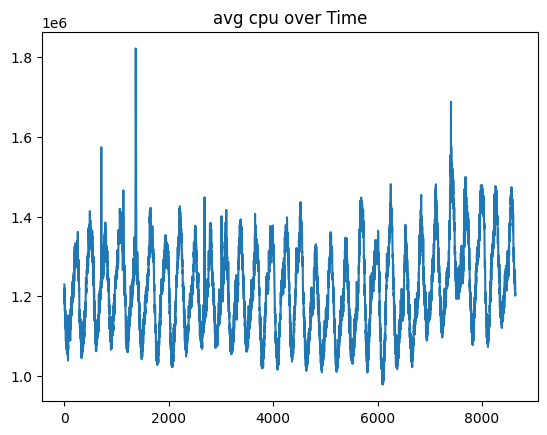

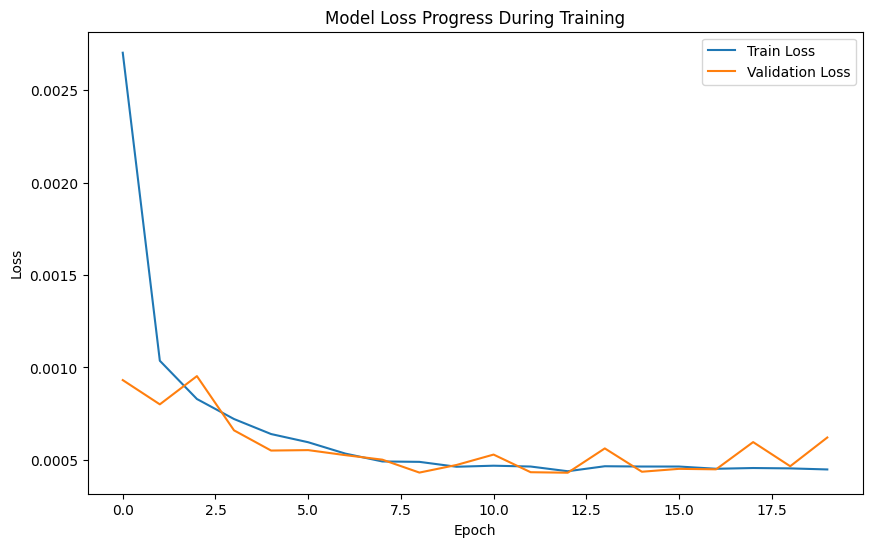

216/216 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Train MSE: 440327870.0
Train RMSE: 20983.99
Train MAE: 17337.258
Train MAPE: 1.4550086110830307
************************************************************
Test MSE: 441813630.0
Test RMSE: 21019.363
Test MAE: 17285.834
Test MAPE: 1.3675573281943798


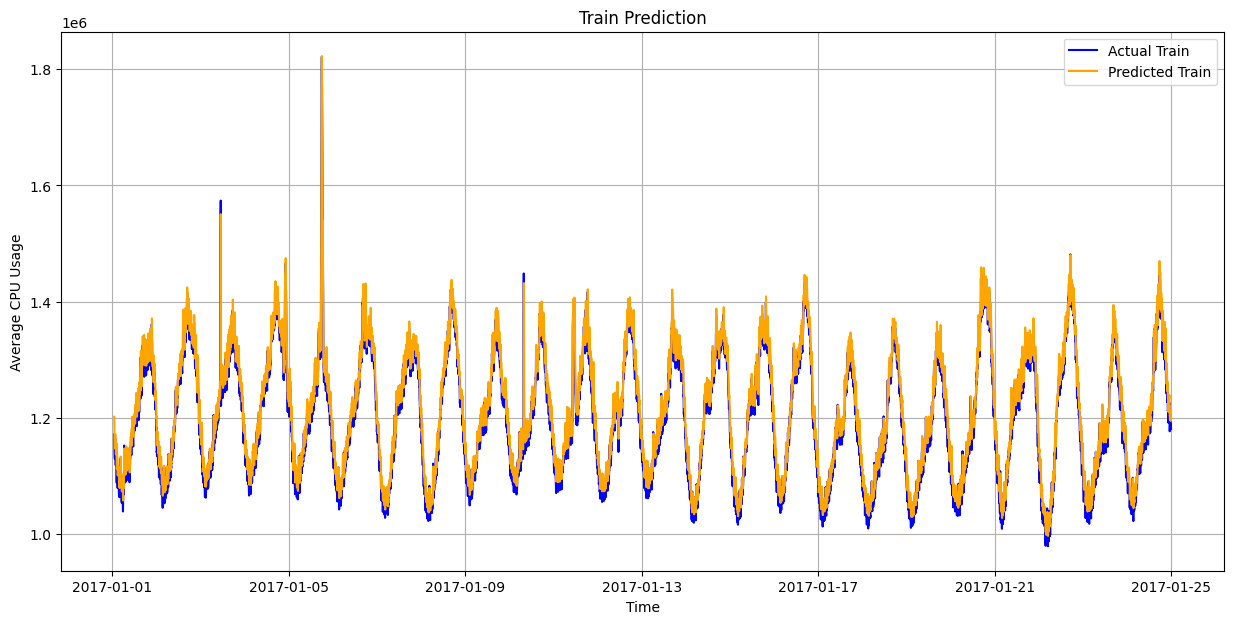

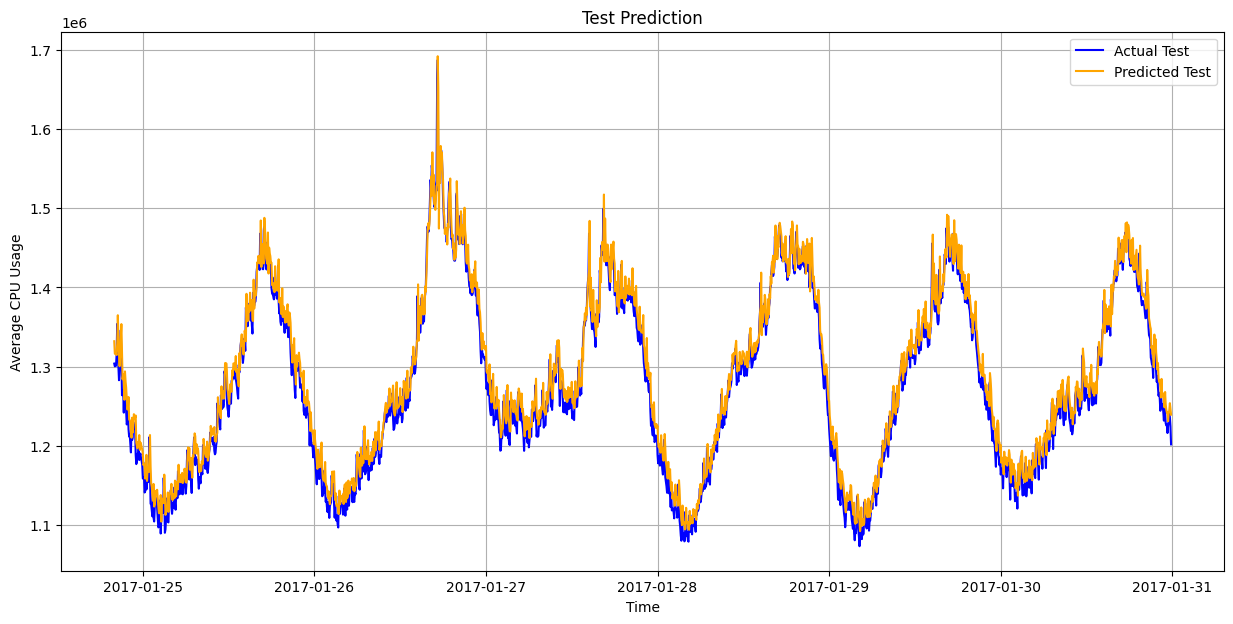

Function: run
CPU time used: 11.50 sec
Memory used: 136.42 MB
Execution time: 41.82 sec


In [6]:
df_azure = pd.read_csv("azure.csv")
azure = LSTM_predictions(df_azure,"avg cpu",epoch=20)
azure.plot(df_azure,"avg cpu")
azure.run()

# Performance on IEEE data while predicting Energy Consumption

In [7]:
df_workstation = pd.read_csv("workstation_data.csv")

Columns:  Index(['timestamp', 'voltage', 'current', 'power', 'frequency', 'energy', 'fp',
       'ESP32_temp', 'WORKSTATION_CPU', 'WORKSTATION_CPU_POWER',
       'WORKSTATION_CPU_TEMP', 'WORKSTATION_GPU', 'WORKSTATION_GPU_POWER',
       'WORKSTATION_GPU_TEMP', 'WORKSTATION_RAM', 'WORKSTATION_RAM_POWER'],
      dtype='object')
Data shape:  (22857, 16)
************************************************************
Train size : (18286, 16)
Test size : (4631, 16)
************************************************************
Train and Test Size after preprocessing: 
X_train shape:  (18273, 12, 1)
y_train shape:  (18273, 1)
X_test shape:  (4618, 12, 1)
y_test shape:  (4618, 1)
************************************************************
Epoch 1/20
572/572 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 0.0097 - val_loss: 2.4767e-05
Epoch 2/20
572/572 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 1.2978e-06 - val_loss: 3.2653e-05
Epoch 3/20
572/572 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 1.5514e-06 - val_l

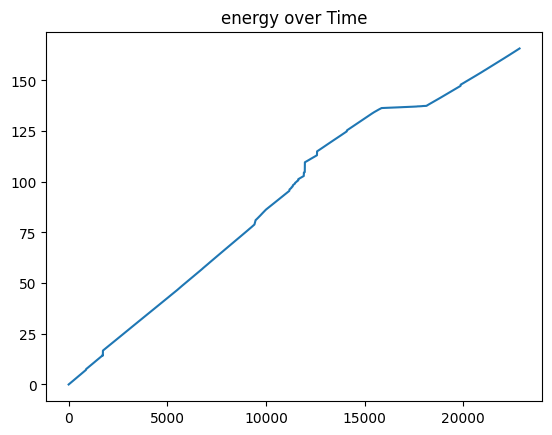

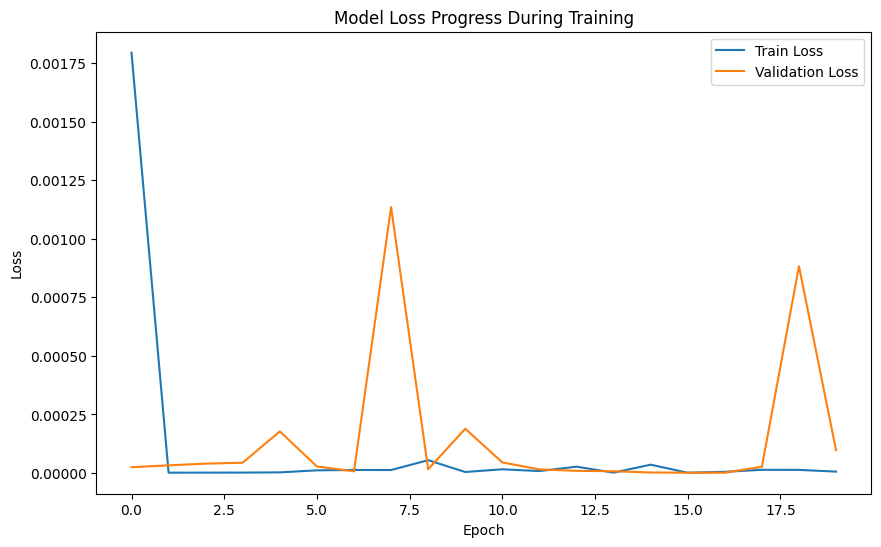

572/572 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Train MSE: 0.33997977
Train RMSE: 0.58307785
Train MAE: 0.472409
Train MAPE: 1.646658033132553
************************************************************
Test MSE: 1.8596089
Test RMSE: 1.3636748
Test MAE: 1.3485328
Test MAPE: 0.8841906674206257


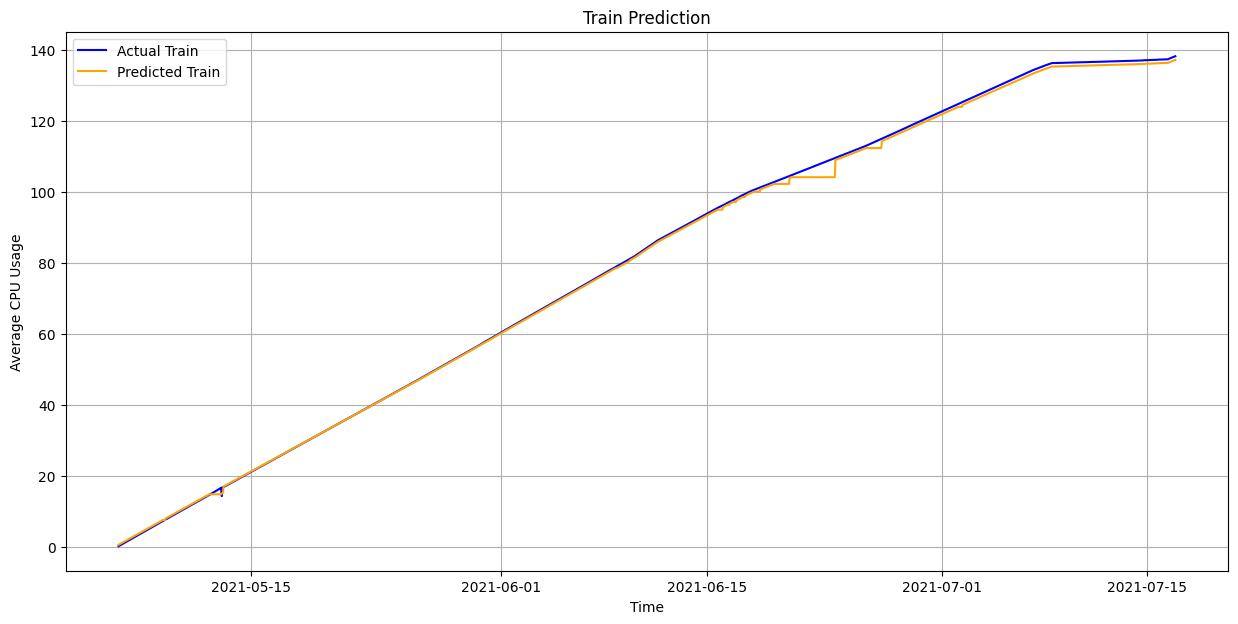

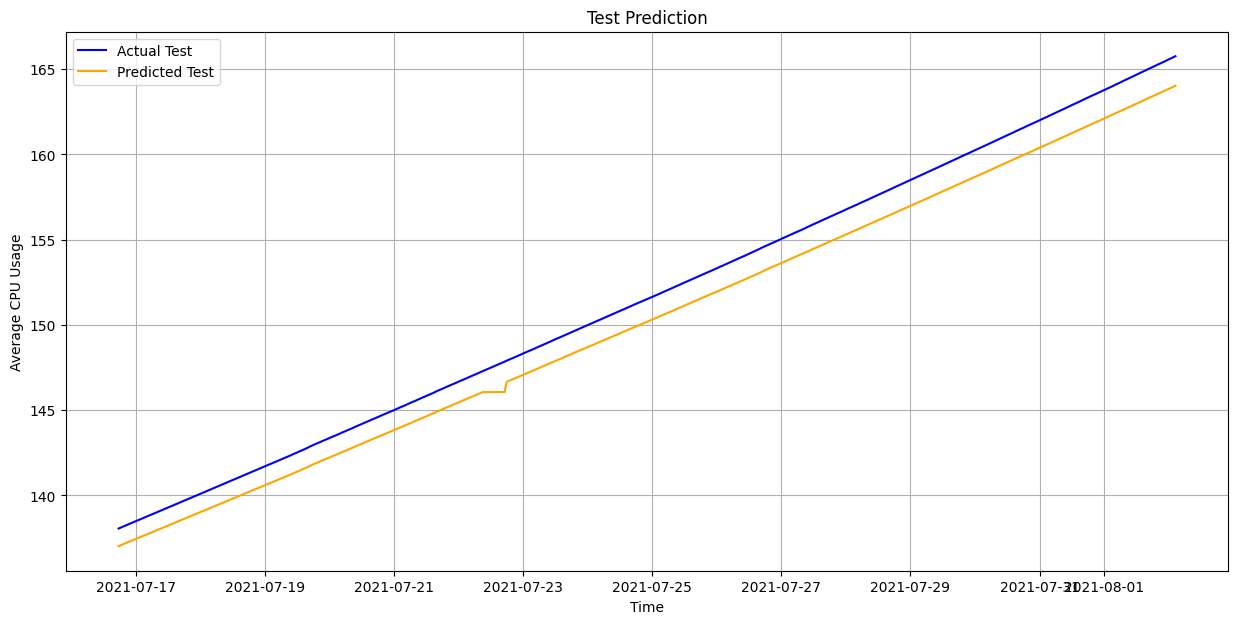

Function: run
CPU time used: 25.88 sec
Memory used: 84.44 MB
Execution time: 98.84 sec


In [8]:
ieee = LSTM_predictions(df_workstation,"energy",epoch=20)
ieee.plot(df_workstation,"energy")
ieee.run()

# Performance on Turing Dataset

In [9]:
df_turing = pd.read_csv("turing_clean.csv")
df_turing["timestamp"] = df_turing['day'] + " " + df_turing['hour']

Columns:  Index(['Unnamed: 0', 'cpu_model_name', 'nb_cpu_cores', 'RAM_size', 'day',
       'hour', 'cpu_freq_limit percent', 'current_cpu_frequency_limits',
       'cpu_usage_percent', 'ram_usage_percent', 'energy_consumption',
       'timestamp'],
      dtype='object')
Data shape:  (410, 12)
************************************************************
Train size : (328, 12)
Test size : (142, 12)
************************************************************
Train and Test Size after preprocessing: 
X_train shape:  (315, 12, 1)
y_train shape:  (315, 1)
X_test shape:  (129, 12, 1)
y_test shape:  (129, 1)
************************************************************
Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 0.1584 - val_loss: 0.0169
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0283 - val_loss: 0.0178
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0175 - val_loss: 0.0170
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0217 - val

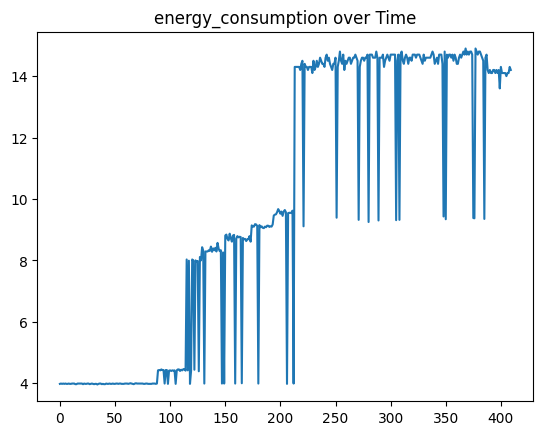

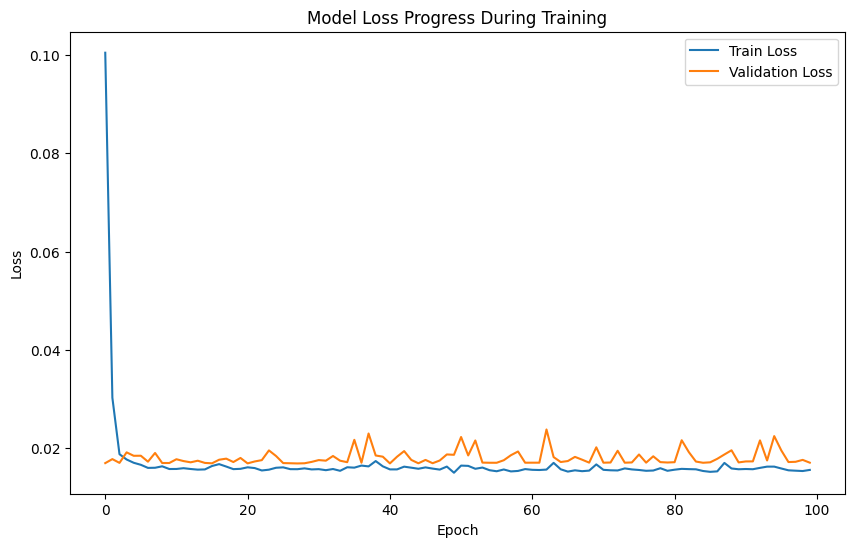

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Train MSE: 1.7678777
Train RMSE: 1.3296156
Train MAE: 0.60898644
Train MAPE: 8.171255886554718
************************************************************
Test MSE: 2.0012054
Test RMSE: 1.4146397
Test MAE: 0.70896274
Test MAPE: 6.177255138754845


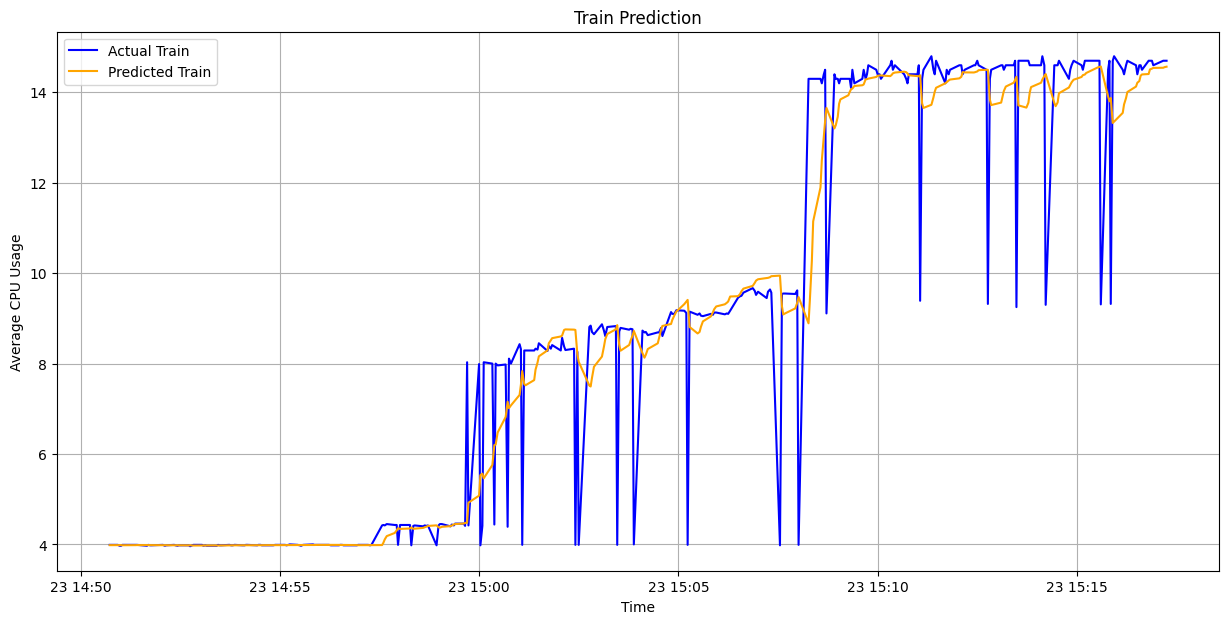

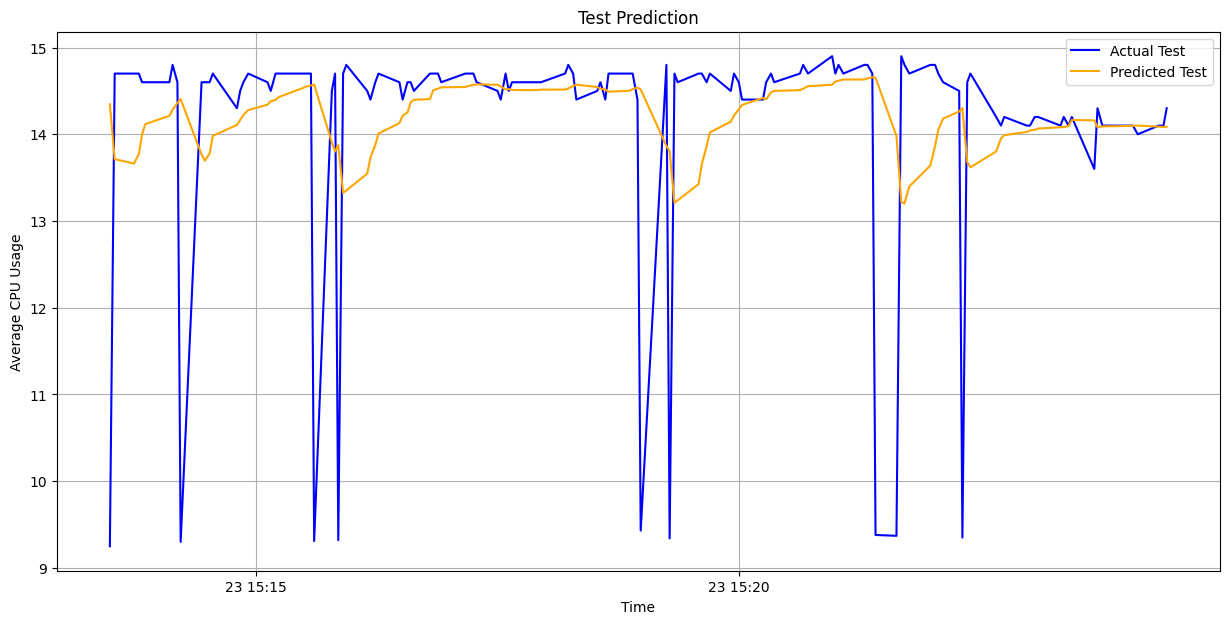

Function: run
CPU time used: 3.52 sec
Memory used: 12.18 MB
Execution time: 17.81 sec


In [10]:
turing = LSTM_predictions(df_turing,"energy_consumption",epoch=100)
turing.plot(df_turing,"energy_consumption")
turing.run()